In [2]:
import openmc
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import kdsource as kds
from mpl_toolkits.mplot3d import Axes3D as ax

In [3]:
openmc_data = "/home/agusgimenez/Desktop/Secciones/endfb-viii.0-hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

In [4]:
mat01 = openmc.Material(material_id=0) #agua
mat01.add_nuclide('H1',2.000,'ao')
mat01.add_nuclide('O16',0.9976,'ao')
mat01.add_nuclide('O17',0.00035,'ao')
mat01.add_s_alpha_beta('c_H_in_H2O')
mat01.set_density('g/cm3',1.00)

In [5]:
W_vacio = 2.5
W_total = 12.5
L       = 300
z_Source= 30

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

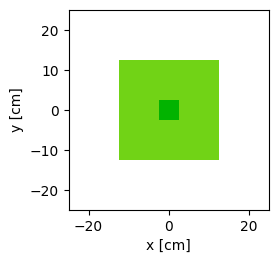

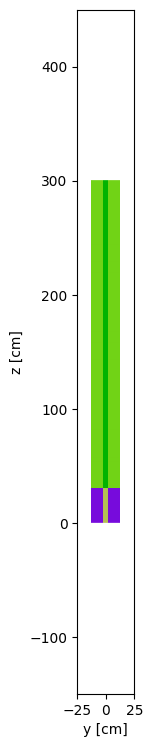

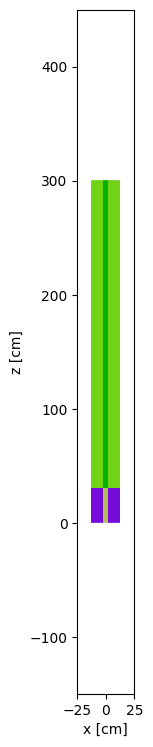

In [6]:
#bloque mat01
surf1_v = openmc.XPlane(-W_vacio)
surf1_v.boundary_type = 'transmission'

surf6_v = openmc.XPlane(W_vacio)
surf6_v.boundary_type = 'transmission'



surf2_v = openmc.YPlane(-W_vacio)
surf2_v.boundary_type = 'transmission'


surf5_v = openmc.YPlane(W_vacio)
surf5_v.boundary_type = 'transmission'

surf1_a = openmc.XPlane(-W_total)
surf1_a.boundary_type = 'vacuum'

surf6_a = openmc.XPlane(W_total)
surf6_a.boundary_type = 'vacuum'

surf2_a = openmc.YPlane(-W_total)
surf2_a.boundary_type = 'vacuum'

surf5_a = openmc.YPlane(W_total)
surf5_a.boundary_type = 'vacuum'



surf3 = openmc.ZPlane(0)
surf3.boundary_type = 'vacuum'

surf_source = openmc.ZPlane(z_Source)
surf_source.boundary_type = "transmission"

surf4 = openmc.ZPlane(L)
surf4.boundary_type = 'vacuum'



cell01_v = openmc.Cell(fill=None,cell_id=1)
cell01_v.region = +surf1_v & -surf6_v & +surf2_v & -surf5_v & +surf3 & -surf_source

cell01_a = openmc.Cell(fill=mat01,cell_id=2)
cell01_a.region = +surf1_a & -surf6_a & +surf2_a & -surf5_a & +surf3 & -surf_source & ~cell01_v.region


cell02_v = openmc.Cell(fill=None,cell_id=3)
cell02_v.region = +surf1_v & -surf6_v & +surf2_v & -surf5_v & +surf_source & -surf4

cell02_a = openmc.Cell(fill=mat01,cell_id=4)
cell02_a.region = +surf1_a & -surf6_a & +surf2_a & -surf5_a & +surf_source & -surf4 & ~cell01_v.region



univ01 = openmc.Universe(cells=[cell01_v,cell01_a,cell02_a,cell02_v],universe_id=1) 
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W_total,4*W_total))
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W_total,2*L),basis='yz')
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W_total,2*L),basis='xz')


In [7]:
S = openmc.Source()
S.particle = 'neutron'
#dist_espacial'

x = openmc.stats.Uniform(W_total,-W_total)
y = openmc.stats.Uniform(W_total,-W_total)
z = openmc.stats.Discrete(0.1,1)
S.space = openmc.stats.CartesianIndependent(x,y,z)

#dist_Energia
S.energy = openmc.stats.Discrete(3e6,1.0)

#dist_angular.

S.angle = openmc.stats.Isotropic()

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/source.py:539: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [8]:
tallies = openmc.Tallies()


#FILTRO PARTICULA
Filtro_particula_neutron    =   openmc.ParticleFilter(['neutron'],filter_id = 0)

#GRILLA

mesh_vacio_xy = openmc.RegularMesh.from_domain(domain=univ01,dimension=(100,100,1),mesh_id=1)
mesh_vacio_xy.lower_left = [-W_total, -W_total, 0]
mesh_vacio_xy.upper_rigth = [W_total, W_total, L]

mesh_vacio_xz = openmc.RegularMesh.from_domain(domain=univ01,dimension=(100,1,500),mesh_id=2)
mesh_vacio_xz.lower_left = [-W_total, -W_total, 0]
mesh_vacio_xy.upper_rigth = [W_total, W_total, L]

mesh_vacio_yz = openmc.RegularMesh.from_domain(domain=univ01,dimension=(1,100,500),mesh_id=3)
mesh_vacio_yz.lower_left = [-W_total, -W_total, 0]
mesh_vacio_yz.upper_rigth = [W_total, W_total, L]

#FILTRO ESPACIAL

filt_vacio_xy = openmc.filter.MeshFilter(mesh_vacio_xy,filter_id=1)
filt_vacio_xz = openmc.filter.MeshFilter(mesh_vacio_xz,filter_id=2)
filt_vacio_yz = openmc.filter.MeshFilter(mesh_vacio_yz,filter_id=3)


#Tallys

dist_vacio_xy = openmc.Tally(name='vacio_xy' , tally_id=1)
dist_vacio_xy.scores = ["flux"]
dist_vacio_xy.filters = [filt_vacio_xy, Filtro_particula_neutron]
tallies.append(dist_vacio_xy)

dist_vacio_xz = openmc.Tally(name='vacio_xz' , tally_id=2)
dist_vacio_xz.scores = ["flux"]
dist_vacio_xz.filters = [filt_vacio_xz, Filtro_particula_neutron]
tallies.append(dist_vacio_xz)

dist_vacio_yz = openmc.Tally(name='vacio_yz' , tally_id=3)
dist_vacio_yz.scores = ["flux"]
dist_vacio_yz.filters = [filt_vacio_yz, Filtro_particula_neutron]
tallies.append(dist_vacio_yz)


In [9]:
#Numero de particulas 
N = int(1E8)

param = openmc.Settings()
param.source = S
param.run_mode = "fixed source"
param.batches = 1
param.particles = N

# Superficies donde escribe las particulas
superficies = [surf_source.id]

param.surf_source_write = {
    'surface_ids': superficies,
    'max_particles': len(superficies)*N,
    'mcpl':True
}

In [10]:
geom = openmc.Geometry(univ01)
geom.export_to_xml()

mats = openmc.Materials(univ01.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()


param.export_to_xml()

tallies.export_to_xml()

In [11]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

rm: cannot remove 'statepoint.*.h5': No such file or directory
rm: cannot remove 'summary.h5': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################    

In [12]:
def get_df_NormVolum(
    tally = openmc.Tally(),
    Plot = False,
    xlabel='x [cm]',
    ylabel='y [cm]'
):
    """Plot 2-D distribution for given spatial variables (xy, xz, yz)

    Returns
    -------    
    matplotlib 2-D plot for the Tally with the proper
    normalization.
    """
    
    mesh = tally.find_filter(openmc.filter.MeshFilter)
    upper_right = mesh.mesh.upper_right
    lower_left  = mesh.mesh.lower_left
    N    = mesh.mesh.dimension    
    DV   = (upper_right-lower_left)/N
    df = tally.get_pandas_dataframe()
    df['mean'] = df['mean']/(DV[0]*DV[1]*DV[2])
    
    print(N)
    print(DV)
    if Plot == True:
        mean = np.array(df['mean'])
        if N[0] == 1:
            extent = (lower_left[1], upper_right[1], lower_left[2],upper_right[2])
            mean.shape=(N[2],N[1])
        elif N[1] == 1:
            extent = (lower_left[0], upper_right[0], lower_left[2],upper_right[2])
            mean.shape=(N[2],N[0])
        elif N[2] == 1:
            extent = (lower_left[0], upper_right[0], lower_left[1],upper_right[1])
            mean.shape=(N[1],N[0])
        else:
            print("X") 
            return df
        
        plt.imshow(mean, origin='lower', interpolation='none', extent=extent, cmap='viridis')
        plt.colorbar()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
    return df
    
    
def get_df_NormEnergy(
    tally = openmc.Tally(),
    Plot = False,
    xlabel1='Energy [ev]',
    E0    = float
):
    """Plot 2-D distribution for given Energy variable (E , u)
    Returns
    -------    
    matplotlib 2-D plot for the Tally with the proper
    normalization.
    """
    
    df = tally.get_pandas_dataframe()
    Emax = df['energy high [eV]']
    Emin = df['energy low [eV]']
    DE = Emax-Emin
    E   = (Emax+Emin)/2
    units = '[n/s]'
    df['mean'] = df['mean']*DE
    
    if Plot == True:
        plt.plot(E,df['mean'])
        ylabel = df['score'][1] + units
        plt.ylabel(ylabel)
        plt.xlabel(xlabel1)
    return df

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(100, 1, 500)
[ 0.25 25.    0.6 ]


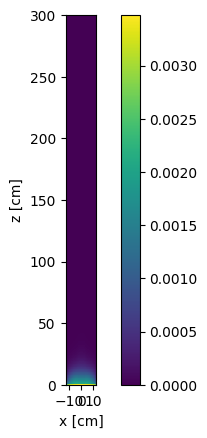

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(100, 100, 1)
[2.5e-01 2.5e-01 3.0e+02]


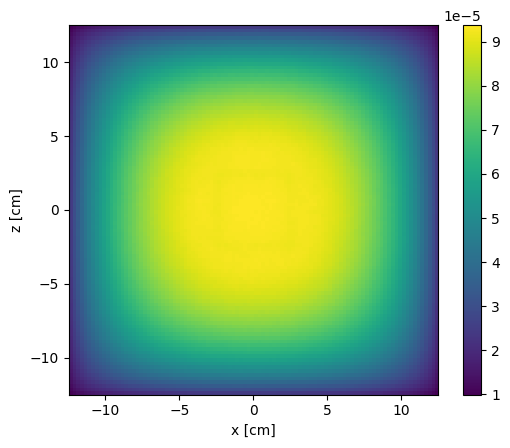

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(1, 100, 500)
[25.    0.25  0.6 ]


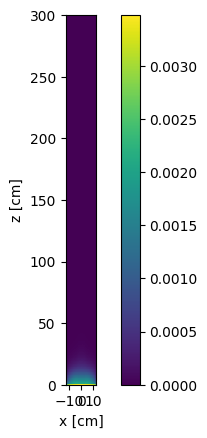

mesh 3           particle nuclide score     mean
           x    y    z                                
0          1    1    1  neutron   total  flux 1.93e-03
1          1    2    1  neutron   total  flux 2.30e-03
2          1    3    1  neutron   total  flux 2.50e-03
3          1    4    1  neutron   total  flux 2.63e-03
4          1    5    1  neutron   total  flux 2.74e-03
...      ...  ...  ...      ...     ...   ...      ...
49995      1   96  500  neutron   total  flux 0.00e+00
49996      1   97  500  neutron   total  flux 0.00e+00
49997      1   98  500  neutron   total  flux 0.00e+00
49998      1   99  500  neutron   total  flux 0.00e+00
49999      1  100  500  neutron   total  flux 0.00e+00

[50000 rows x 7 columns]

In [13]:
sp = openmc.StatePoint("statepoint.1.h5")
tally_vacio_xy  = sp.get_tally(name='vacio_xy')
tally_vacio_xz  = sp.get_tally(name='vacio_xz')
tally_vacio_yz  = sp.get_tally(name='vacio_yz')
get_df_NormVolum(tally_vacio_xz,Plot=True,ylabel='z [cm]')
get_df_NormVolum(tally_vacio_xy,Plot=True,ylabel='z [cm]')
get_df_NormVolum(tally_vacio_yz,Plot=True,ylabel='z [cm]')

In [24]:
Plano_1 = kds.surfsource.SurfaceSourceFile('surface_source.mcpl',domain={'w':[0,1]}) 
Plano_1.save_source_file('SurfSource_30cm_8-6.mcpl')
plist_1 = kds.PList("SurfSource_30cm_8-6.mcpl.gz")
geometry_1 = kds.Geometry([kds.geom.Energy(),kds.geom.SurfXY(xmin=-W_total,xmax=W_total,ymin=-W_total,ymax=W_total),kds.geom.Isotrop()])
S_1 = kds.KDSource(plist_1,geometry_1)


Number of particles in file surface_source.mcpl: 1097931
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Saving into MCPL format
Saving into SSV format (ASCII)
Done, saved into temp.txt file
ssv_open_file: Opened file "temp.txt":
MCPL: Attempting to compress file SurfSource_30cm_8-6.mcpl with gzip
MCPL: Succesfully compressed file into SurfSource_30cm_8-6.mcpl.gz
Created SurfSource_30cm_8-6.mcpl.gz
Done, saved into SurfSource_30cm_8-6.mcpl file
Using existing file SurfSource_30cm_8-6.mcpl.gz
sum_weights = 698913.0
p2 = 698913.0
N = 698913
N_eff = 698913.0


In [25]:
var_importance = [5,1,1,1,1,1]

parts,ws = S_1.plist.get(N=-1)
scaling = S_1.geom.std(parts=parts)
scaling /= var_importance

# Number of particles to use for optimization.
# A large number (1E5 or more) gives better bandwidths, but takes longer to
# compute.
N = 1E5

Using 100000 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[0.0579116  1.53608055 1.53900595 0.12424495 0.12424495 0.12424495]]
Using 100000 particles for fit.
Calculating bw ... 
Using k = 10 neighbors per batch (batch_size = 10000)
Correction factor: f_k = k_float / k = 1.0
Effective total neighbors: K_eff = 100.0
batch = 1 / 10


batch = 2 / 10
batch = 3 / 10
batch = 4 / 10
batch = 5 / 10
batch = 6 / 10
batch = 7 / 10
batch = 8 / 10
batch = 9 / 10
batch = 10 / 10
Done
Optimal bw (knn) = [[0.08633144 2.28990475 2.29426577 0.18521756 0.18521756 0.18521756]
 [0.19303124 5.12007171 5.12982266 0.41413391 0.41413391 0.41413391]
 [0.08905311 2.362096   2.36659451 0.19105671 0.19105671 0.19105671]
 ...
 [0.14924645 3.95869858 3.96623774 0.32019694 0.32019694 0.32019694]
 [0.32163859 8.53132696 8.54757449 0.69005123 0.69005123 0.69005123]
 [0.07728981 2.05007938 2.05398366 0.16581943 0.16581943 0.16581943]]
Using 10000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


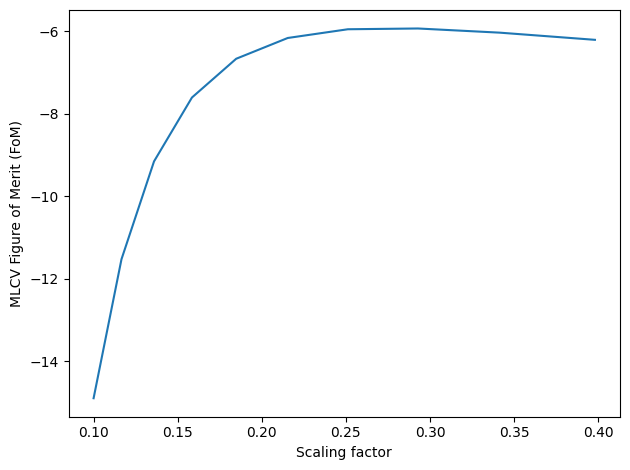

Done
Optimal bw (mlcv) = [[0.02528341 0.67063171 0.6719089  0.05424364 0.05424364 0.05424364]
 [0.05653199 1.49948702 1.50234272 0.1212851  0.1212851  0.1212851 ]
 [0.02608049 0.69177396 0.69309142 0.05595372 0.05595372 0.05595372]
 ...
 [0.03631753 0.96330706 0.96514164 0.07791651 0.07791651 0.07791651]
 [0.02626968 0.69679204 0.69811905 0.0563596  0.0563596  0.0563596 ]
 [0.05172265 1.3719214  1.37453416 0.11096703 0.11096703 0.11096703]]
Using 100000 particles for fit.


In [26]:
S_1.bw_method = "silv"
S_1.fit(N, scaling=scaling)

# Method 3: Adaptive Maximum Likelihood Cross-Validation:
# Creates a grid of adaptive bandwidths and evaluates the
# cross-validation scores on each one, which is an indicator of the
# quality of the estimation. Selects the bandwidth that optimizes
# CV score.
# kNN is used to generate the seed adaptive bandwidth.

# kNN bandwidth
S_1.bw_method = "knn"
batch_size = 10000 # Batch size for KNN search
k = 10             # Numer of neighbors per batch
S_1.fit(N, scaling=scaling, batch_size=batch_size, k=k)
bw_knn = S_1.kde.bw

# MLCV optimization of previously calculated kNN bandwidth
S_1.bw_method = "mlcv"
N_cv = int(1E4)   # Use a smaller N to reduce computation times
seed = bw_knn[:N_cv] # Use kNN BW as seed (first N elements)
grid = np.logspace(-1,-0.4,10)
S_1.fit(N_cv, scaling=scaling, seed=seed, grid=grid)
bw_cv = S_1.kde.bw

# Extend MLCV optimization to full KNN BW
bw_knn_cv = bw_knn * bw_cv[0]/bw_knn[0] # Apply MLCV factor
dim = S_1.geom.dim
bw_knn_cv *= kds.bw_silv(dim,len(bw_knn))/kds.bw_silv(dim,len(bw_cv)) # Apply Silverman factor
S_1 = kds.KDSource(plist_1, geometry_1, bw=bw_knn_cv) # Create new KDSource with full BW
S_1.fit(N=N, scaling=scaling)

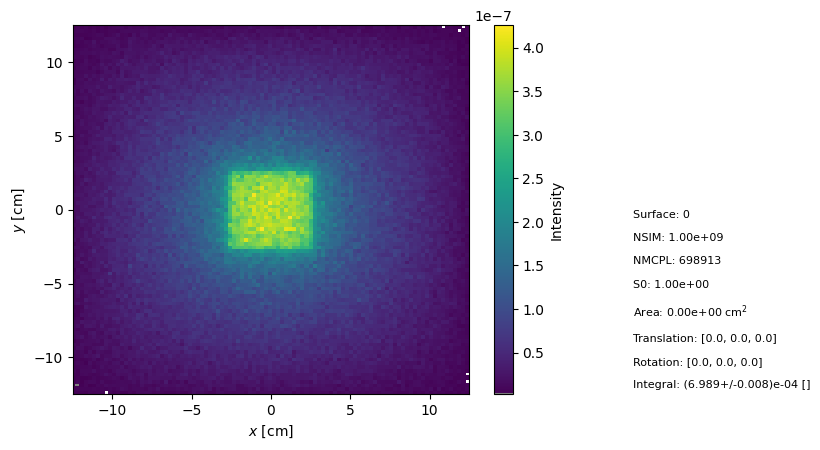

In [27]:
Plano_1.plot_distribution(vars=['x','y'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True, zscale='linear')

In [28]:
Plano_1.get_pandas_dataframe()

,id,type,E,x,y,z,u,v,w,t,...,pz,userflags,R,theta,mu,psi,phi,ln(E0/E),log(t),lambda
0,0,2112.0,6.644120e-08,-0.573091,-1.010321,30.0,0.579350,-0.451064,0.678892,0.076168,...,0.0,0.0,1.161543,-2.086776,0.678892,0.824543,-0.661535,19.522681,-1.118230,1.109607
1,1,2112.0,3.835331e-01,4.178236,1.016415,30.0,-0.184015,0.145675,0.972068,0.000020,...,0.0,0.0,4.300087,0.238629,0.972068,0.236907,2.471965,3.954062,-4.696101,0.000462
3,3,2112.0,7.414383e-09,3.109982,4.973844,30.0,0.089058,-0.028847,0.995609,0.281530,...,0.0,0.0,5.866099,1.012005,0.995609,0.093751,-0.313253,21.715576,-0.550475,3.321623
5,5,2112.0,1.300657e-08,2.975942,4.577095,30.0,0.551989,0.101119,0.827697,0.290733,...,0.0,0.0,5.459490,0.994294,0.827697,0.595804,0.181181,21.153543,-0.536505,2.507878
6,6,2112.0,1.670934e+00,5.491349,-0.426567,30.0,0.218734,0.545594,0.809001,0.000014,...,0.0,0.0,5.507892,-0.077524,0.809001,0.628346,1.189506,2.482349,-4.867498,0.000221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097923,1097923,2112.0,4.628587e-08,0.546392,1.062888,30.0,0.514296,-0.588280,0.624041,0.323655,...,0.0,0.0,1.195105,1.095961,0.624041,0.896893,-0.852399,19.884161,-0.489918,1.329424
1097924,1097924,2112.0,6.243710e-08,-0.829247,6.606147,30.0,-0.206813,-0.167036,0.964016,0.222147,...,0.0,0.0,6.657990,1.695670,0.964016,0.269078,-2.462193,19.584838,-0.653360,1.144633
1097926,1097926,2112.0,8.752318e-02,4.807038,-4.679544,30.0,-0.414676,-0.822173,0.389968,0.000027,...,0.0,0.0,6.708632,-0.771960,0.389968,1.170200,-2.037930,5.431584,-4.570368,0.000967
1097928,1097928,2112.0,3.542121e-03,4.847895,-5.388199,30.0,-0.491397,-0.253115,0.833344,0.000032,...,0.0,0.0,7.248088,-0.838133,0.833344,0.585667,-2.665945,8.638762,-4.490509,0.004806
